In [1]:
import sta_clustering_core

import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
print(sta_clustering_core.__version__)

2.0.3


In [3]:
print(pd.__version__)

1.1.0


#### Preparation
* Load data into Python
* Drop empty or very short texts
* Choose number of clusters (e.g. 12)

#### Clustering
* Create the *feature matrix* by converting the text content into a word frequency map with tf-idf weighting
* Cluster the documents using non-negative matrix factorisation (NMF)
* Inspect the resulting compressed matrices to determine
    * Cluster assignment of each document
    * Cluster size
    * Top words for each cluster
    
#### Visualise the results
* Confusion matrix
* Positions of clusters in the latent space (pyLDAvis)

In [17]:
from typing import List
from sta_clustering_core.core.datamodel import RefCase

def df_to_refcases(df: pd.DataFrame) -> List[RefCase]:
    """Converts the dataframe to RefCases, the internal format for STA"""
    result = []
    for _idx, row in df.iterrows():
        try:
            text = row['Machine Translation (beta): English'].replace('agile', '').replace('Agile', '')
            result.append(RefCase(
                _idx,  # row['Case Number'],
                # row['Machine Translation (beta): English'],  # row['Subject'],
                text,
                '',  # row['Description'],
                '',  # row['Solution Description'],
                [],  # parse_entity_list(row['Subject_entities']),
                [],  # parse_entity_list(row['Desc_entities']),
                [],  # parse_entity_list(row['Soln_entities']),
                '',  # row['Product Family'],
                ''  # row['Equipment: Serial Number']
            ))
        except UnicodeError as ue:
            print(ue)
            print(row)
            
    return result

In [18]:
datafile = '/home/z0017wrp/work/projects/sges_sop_it/first analysis/Comment_SOP IT_Customer Value_Veronika_with tags.xlsx'
data = pd.read_excel(datafile)

print(f'Loaded {data.shape[0]} records')
print(data.columns)
data.set_index('id', inplace=True)

# get rid of NAs in the Action Field - replace with "missing"
data['Action Field'] = data['Action Field'].fillna('Missing')

data.dropna(axis=0, subset=['Machine Translation (beta): English'], inplace=True)
print(f'After dropping empty records, we have {data.shape[0]} records')

# Drop short documents, since they are likely to end up as empty docs after projection into feature space
min_text_length_chars = 20
data = data[data['Machine Translation (beta): English'].map(len) > min_text_length_chars]
print(f'After dropping short texts, we have {data.shape[0]} records')

refcases = df_to_refcases(data)
print(f'Loaded {len(refcases)} RefCases')


Loaded 453 records
Index(['id', 'Sentiment', 'Category', 'Type', 'Sub Category',
       'Machine Translation (beta): English', 'Detected Language',
       'Action Field', 'Topic (Problem statement)', 'Tag 1', 'Tag 2', 'Tag 3',
       'Suggestion (evtl. own wording)', '6 Action Fields'],
      dtype='object')
After dropping empty records, we have 451 records
After dropping short texts, we have 427 records
Loaded 427 RefCases


## Configuration for clustering

In [24]:
from sta_clustering_core.core.config_handling import pretty_print_config
import configparser
import pkgutil

# Construct the config object
config = configparser.ConfigParser()

# first, read the defaults
config.read_string(pkgutil.get_data('sta_clustering_core.resources', 'defaults.conf').decode())

# then add further config choices
config.set('clustering', 'output.file_clusters', 'None')
config.set('clustering', 'output.file_cases', 'None')
config.set('clustering', 'output.per_cluster_filepattern', 'None')
config.set('clustering', 'output.cluster_distribution_filename', 'None')

num_clusters = 20
config.set('clustering', 'cluster.num_clusters', str(num_clusters))
    
pretty_print_config(config)

[clustering]
  weight.subj_text:	1
  weight.subj_ent:	1
  weight.desc_text:	1
  weight.desc_ent:	1
  weight.soln_text:	1
  weight.soln_ent:	1
  tokenisation.min_ngram:	2
  tokenisation.max_ngram:	3
  tokenisation.drop_list:	turbin|siemen
  tokenisation.do_stemming:	True
  tokenisation.remove_stopwords:	True
  tokenisation.text_language:	en
  features.min_doc_length:	0
  features.use_tf_idf:	True
  features.normalise:	True
  features.min_df:	1
  features.num_best_features:	10000
  features.parallelisation:	1
  cluster.num_clusters:	20
  cluster.algorithm:	nmf
  cluster.write_matrices:	False
  input.sep:	tab
  logging.thresholds.min_vocab_overlap:	0.5
  logging.thresholds.norm_ent_overlap:	0.5
  output.num_top_words:	10
  output.list_sep:	|
  output.file_clusters:	None
  output.file_cases:	None
  output.per_cluster_dir:	per_cluster
  output.per_cluster_filepattern:	None
  output.feature_freqs:	None
  output.cluster_distribution_filename:	None
  store.model.filename:	model.tar.gz


## Train the clustering model

In [25]:
from sta_clustering_core.core.interface import main_aux_from_data

model_version = 'sges_2020'
mp = main_aux_from_data(refcases, config, model_version, draw_plot=None)

/home/z0017wrp/.conda/envs/sges-sop-it/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:2686: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


## Inspect the top words and cluster sizes

Text(0.5, 1.0, 'Distribution of cluster sizes')

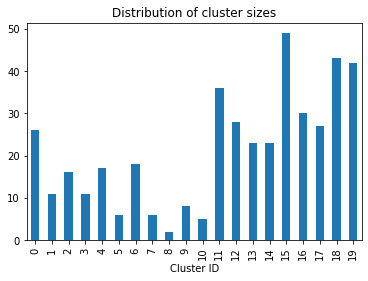

In [26]:
cluster_assignments = pd.DataFrame(mp.cluster_label_for_cases.items(), columns=['id', 'cluster_id'])
cluster_assignments = cluster_assignments.set_index('id')

cluster_sizes = cluster_assignments.cluster_id.value_counts(sort=False)
axes = cluster_sizes.plot.bar()
axes.set_xlabel('Cluster ID')
axes.set_title('Distribution of cluster sizes')



In [14]:
# write the cluster assignments to file
cluster_assignments.to_csv('send/cluster_assignments.csv')

In [27]:
# get the cluster sizes along with their top words

info = []
for i in range(num_clusters):
    cluster_i_info = {
        'cluster_id': i,
        'cluster_size': cluster_sizes[i]   
    }
    for idx, word in enumerate(mp.cluster_top_words[i]):
        cluster_i_info['top_word_%s' % idx] = word
    info.append(cluster_i_info)

cluster_info = pd.DataFrame(info)
cluster_info = cluster_info.set_index('cluster_id')

cluster_info


,cluster_size,top_word_0,top_word_1,top_word_2,top_word_3,top_word_4,top_word_5,top_word_6,top_word_7,top_word_8,top_word_9
cluster_id,,,,,,,,,,,
0,26,work method,custom benefit,quick work method,benefit quick,quick work,benefit quick work,custom benefit quick,implement wherev,wherev possibl,method implement
1,11,work mode,boost work,boost work mode,alreadi small,small chapter,chapter work,alreadi small chapter,chapter work mode,small chapter work,structur work
2,16,way work,alreadi use,alreadi use way,use way,use way work,old way,old way work,still stuck,still stuck old,stuck old
3,11,custom valu,creat custom,creat custom valu,us creat custom,leadership motiv us,leadership motiv,motiv us,custom valu fast,motiv us creat,us creat
4,17,team member,communic team,improv direct communic,communic team member,direct communic team,direct communic,improv direct,locat frequent,team member locat,frequent meet
5,6,cross collabor,cross collabor transpar,collabor transpar,work togeth,togeth cross collabor,keep work,keep work togeth,work togeth cross,togeth cross,task alreadi ignit
6,18,valu custom,creat valu,creat valu custom,work like,custom custom,work like labor,valu consider,valu consider organ,valu custom custom,custom custom valu
7,6,initi initi,share session,knowledg share,knowledg share session,project manag,promot project,promot project manag,session promot project,session promot,manag team
8,2,regular communic,regular communic employe,communic employe,regular communic specialist,communic specialist,specialist depart,communic specialist depart,open chang,help better,thing chang


In [40]:
sample_cluster = 8
max_docs = 50
predicted_data = data.join(cluster_assignments)

for idx, row in list(predicted_data[predicted_data.cluster_id == sample_cluster].iterrows())[:max_docs]:
    print(f'{idx}  {row["Detected Language"]}: {row["Machine Translation (beta): English"]}')

9acc4e6dbab921f95bb64bf63fb2dd1246a46004  de: Regular communication with the specialist department.
02608f307dd2ada64ddc154caa1362e332491130  en: Regular Communication with the employee


In [13]:
# write the cluster info to file
cluster_info.to_csv('send/cluster_info.csv')

## Draw the confusion matrix

{'Corporate Culture & Working environment': 0, 'Operational Excellence': 1, 'Personal & professional development': 2, 'Leadership behavior': 3, 'Strategy & Direction': 4, 'Health, Comp&Ben, Work-Life Balance': 5, 'Missing': 6}
{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15, 16: 16, 17: 17, 18: 18, 19: 19}
[[12.  9.  7.  7. 14.  4. 14.  5.  2.  4.  4. 27. 19. 14. 15. 25. 20. 18.
  24. 22.]
 [ 2.  0.  3.  2.  1.  1.  2.  0.  0.  3.  1.  6.  2.  4.  1. 10.  4.  5.
   5.  7.]
 [ 3.  0.  2.  0.  1.  1.  0.  1.  0.  0.  0.  2.  3.  3.  0.  7.  2.  0.
   4.  2.]
 [ 1.  0.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  3.  1.  3.  1.  0.  0.
   2.  3.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  2.  0.  1.
   0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  1.]
 [ 7.  2.  3.  1.  1.  0.  2.  0.  0.  1.  0.  1.  1.  1.  3.  4.  4.  3.
   8.  6.]]
['Corporate Culture & Working enviro

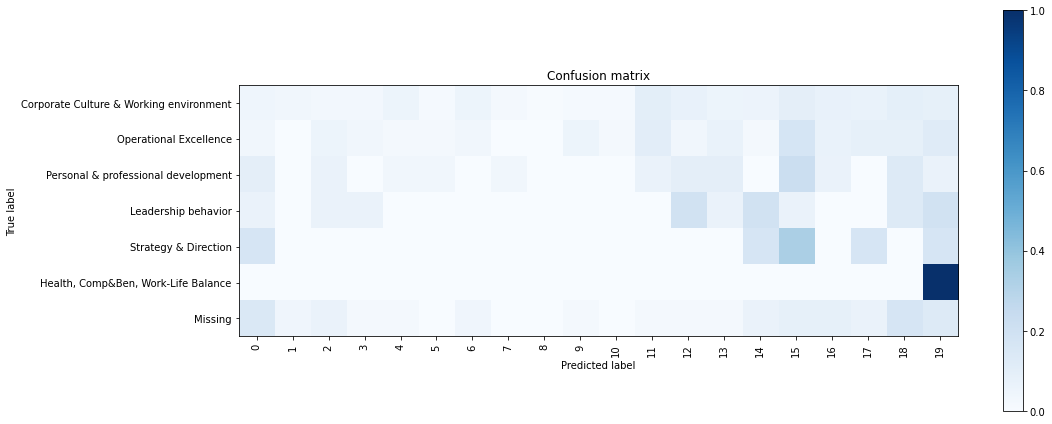

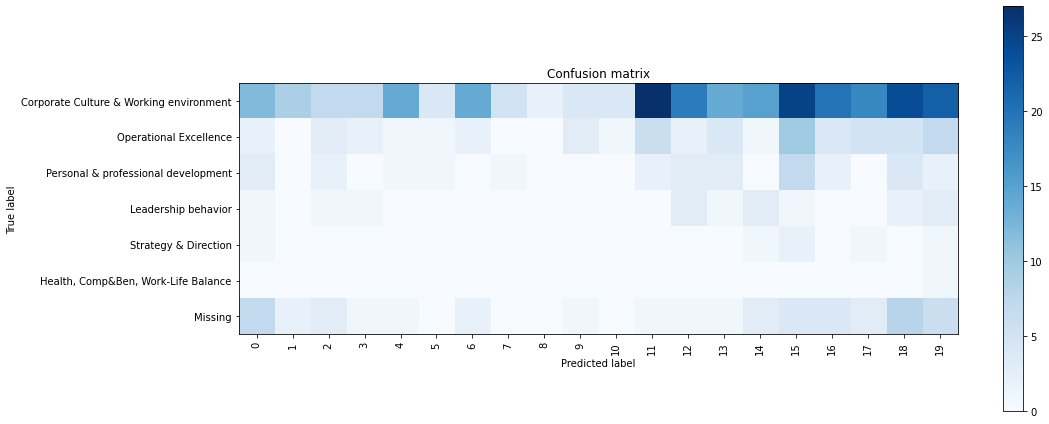

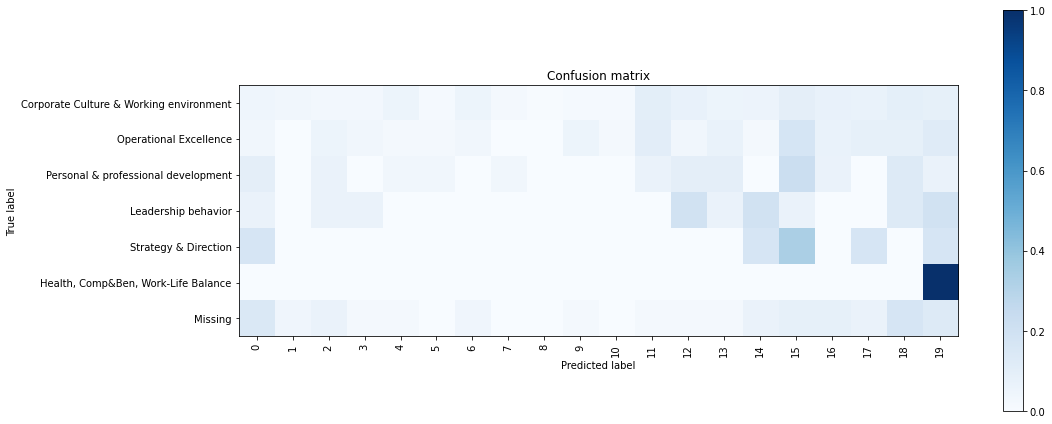

In [29]:
# Confusion matrix

import numpy as np
from typing import Tuple
from sklearn.preprocessing import normalize


def non_square_confusion_matrix(actual: List, predicted: List, 
                                actual_ordered: List=None, 
                                predicted_ordered: List=None) -> Tuple[np.ndarray, List[str], List[str]]:
    """Computes a confusion matrix for non-identical classes."""
    assert len(actual) == len(predicted)
    
    if actual_ordered:
        actual_unique = actual_ordered
    else:
        actual_unique = sorted(list(set(actual)))
    actual_indices = {a_label: i for i, a_label in enumerate(actual_unique)}
    print(actual_indices)
    
    if predicted_ordered:
        predicted_unique = predicted_ordered
    else:
        predicted_unique = sorted(list(set(predicted)))
    predicted_indices = {a_label: i for i, a_label in enumerate(predicted_unique)}
    print(predicted_indices)
    
    confmat = np.zeros((len(actual_unique), len(predicted_unique)))
    
    for act,pred in zip(actual, predicted):
        a_idx = actual_indices[act]
        p_idx = predicted_indices[pred]
        confmat[a_idx, p_idx] = confmat[a_idx, p_idx] + 1
    
    return confmat, actual_unique, predicted_unique


def plot_confusion_matrix(cm, true_labels, predicted_labels, 
                          title='Confusion matrix', cmap=None):
    """
    Plots a given confusion matrix

    :param cm: the confusion matrix, a matrix of integers
    :param category_labels: A list of category labels in the same order as the indices of the confusion matrix
    :param title:
    :param cmap: a matplotlib colour map
    :return:
    """

    if not cmap:
        cmap = plt.cm.Blues

    f, ax = plt.subplots(figsize=(16, 6))

    cax = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title)

    tick_marks = np.arange(len(predicted_labels))
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(predicted_labels, rotation=90)

    tick_marks = np.arange(len(true_labels))
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(true_labels)

    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')

    f.colorbar(cax)
    f.tight_layout()

    return f


data_with_clusterid = pd.concat([data, cluster_assignments], axis=1, join='inner')
data_with_clusterid.head()

# Move "Missing" to the end
actual_label_list = data_with_clusterid['Action Field'].value_counts().index.tolist()
actual_label_list.append(actual_label_list.pop(actual_label_list.index('Missing')))
        
confmat, actual_names, predicted_names = non_square_confusion_matrix(data_with_clusterid['Action Field'].tolist(), 
                                                                     data_with_clusterid.cluster_id.tolist(),
                                                                     actual_ordered=actual_label_list,
                                                                     predicted_ordered=range(num_clusters))

print(confmat)
print(actual_names)
print(predicted_names)

plot_confusion_matrix(confmat, actual_names, predicted_names)

norm_confmat = normalize(confmat, axis=1, norm='l1')
plot_confusion_matrix(norm_confmat, actual_names, predicted_names)



In [33]:
"""Utility functions to prepare data for pyLDAvis."""
from configparser import ConfigParser
from typing import Any
from typing import Dict
from typing import List
from typing import Sequence

from pyLDAvis.sklearn import _get_doc_lengths
from pyLDAvis.sklearn import _get_doc_topic_dists
from pyLDAvis.sklearn import _get_term_freqs
from pyLDAvis.sklearn import _get_topic_term_dists
from sta_clustering_core.core.datamodel import RefCase
from sta_clustering_core.core.features import create_feature_dicts
from sta_clustering_core.core.features import create_weights_vector
from sta_clustering_core.core.model_persistence import ModelPersister


def mp_to_pyldavis_input(
    mdl_perst: ModelPersister, refcases: Sequence[RefCase], config: ConfigParser
) -> Dict[str, Any]:
    """
    Create the input to pyLDAvis.prepare from an MP object.

    See pyLDAvis.sklearn.prepare._extract_data, which this code is adapted from

    Parameters
    ----------
    mdl_perst
    refcases:
        The training data again
    config:
        The same config object as was used to train the model in the first place

    Returns
    -------
    Dict[str, Any]
        The necessary input to pyLDAvis.prepare
    """
    # get all of the config params we need
    weights = create_weights_vector(config)
    min_ngram = config.getint('clustering', 'tokenisation.min_ngram')
    max_ngram = config.getint('clustering', 'tokenisation.max_ngram')

    drop_list_conf_arg = config.get('clustering', 'tokenisation.drop_list')
    if drop_list_conf_arg == 'None':
        drop_list = []
    else:
        drop_list = drop_list_conf_arg.split('|')
    do_stemming = config.getboolean('clustering', 'tokenisation.do_stemming')
    remove_stopwords = config.getboolean(
        'clustering', 'tokenisation.remove_stopwords'
    )
    text_language = config.get('clustering', 'tokenisation.text_language')
    parallelisation = config.getint('clustering', 'features.parallelisation')

    lda_model = mdl_perst.model
    feat_dicts = create_feature_dicts(
        refcases,
        weights,
        min_ngram,
        max_ngram,
        do_stemming,
        parallelisation,
        drop_list,
        text_language,
        remove_stopwords,
    )
    
    # drop empty documents, ie with no non-zero features
    feat_dicts = [fd for fd in feat_dicts if fd]
    
    dtm = mdl_perst.vec.transform(feat_dicts)
#     print(type(dtm))
#     print('nans?')
#     dtm_sums = dtm.sum(axis=1)
#     print(dtm_sums[np.isnan(dtm_sums)])
#     print(dtm_sums[dtm_sums == 0.0])

    vocab: List[str] = mdl_perst.vec.feature_names_
    doc_lengths = _get_doc_lengths(dtm)
    term_freqs = _get_term_freqs(dtm)
    topic_term_dists = _get_topic_term_dists(lda_model)

    assert term_freqs.shape[0] == len(vocab), (
        'Term frequencies and vocabulary '
        'are of different sizes, {} != {}.'.format(
            term_freqs.shape[0], len(vocab)
        )
    )

    assert topic_term_dists.shape[1] == dtm.shape[1], (
        'Topic-term distributions and document-term matrix'
        ' have different number of columns, {} != {}.'.format(
            topic_term_dists.shape[1], len(vocab)
        )
    )

    # column dimensions of document-term matrix and topic-term distributions
    # must match first before transforming to document-topic distributions
    doc_topic_dists = _get_doc_topic_dists(lda_model, dtm)

    return {
        'vocab': vocab,
        'doc_lengths': doc_lengths,  # .tolist(),
        'term_frequency': term_freqs,  # .tolist(),
        'doc_topic_dists': doc_topic_dists,  # .tolist(),
        'topic_term_dists': topic_term_dists  # .tolist()
    }

## View the clustering space with pyLDAvis

In [34]:
import pyLDAvis
# from sges_sop_it.pyldavis_wrapper import mp_to_pyldavis_input

pyLDAvis.enable_notebook()

pyldavis_input = mp_to_pyldavis_input(mp, refcases, config)

vis_nmf = pyLDAvis.prepare(**pyldavis_input)


/home/z0017wrp/.conda/envs/sges-sop-it/lib/python3.6/site-packages/pyLDAvis/_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
/home/z0017wrp/.conda/envs/sges-sop-it/lib/python3.6/site-packages/pyLDAvis/_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
/home/z0017wrp/.conda/envs/sges-sop-it/lib/python3.6/site-packages/pyLDAvis/_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)


In [35]:
# display the pyLDAvis
vis_nmf

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
15     0.062476  0.060283       1        1  12.167502
11     0.009045  0.022381       2        1  10.984989
12     0.000398 -0.131722       3        1   8.270310
19     0.042449  0.113281       4        1   7.890182
18    -0.046158  0.095955       5        1   7.855857
0     -0.182593  0.150076       6        1   7.521946
6      0.167586  0.112774       7        1   6.499511
4     -0.068291  0.038787       8        1   4.932224
2     -0.022841  0.236663       9        1   4.641414
16     0.169199 -0.153081      10        1   4.484064
13    -0.113058  0.078478      11        1   4.387960
14     0.027122  0.014350      12        1   4.342555
17    -0.161008 -0.273981      13        1   4.221597
3     -0.245859 -0.160389      14        1   3.626686
9      0.245972 -0.005257      15        1   2.822496
1     -0.006908  0.006794      16        1   2.142096
5     -0.080485  0.028019      17        1   1.490962
7     -0.082374 -0.074378      18        1   0.981835
10     0.245769 -0.160711      19        1   0.643568
8      0.039558  0.001679      20        1   0.092248, topic_info=                   Term          Freq      Total Category  logprob  loglift
2748         fewer meet  4.200000e+01  42.000000  Default  30.0000  30.0000
6684          step step  3.400000e+01  34.000000  Default  29.0000  29.0000
4324          meet work  3.100000e+01  31.000000  Default  28.0000  28.0000
2750    fewer meet work  3.100000e+01  31.000000  Default  27.0000  27.0000
761           bill tool  2.600000e+01  26.000000  Default  26.0000  26.0000
...                 ...           ...        ...      ...      ...      ...
7034         team chang  5.298089e-24   0.231137  Topic20 -55.6762 -45.1415
1063  chang scope chang  5.298089e-24   0.231137  Topic20 -55.6762 -45.1415
7207  thing chang scope  5.298089e-24   0.231137  Topic20 -55.6762 -45.1415
5951          relev tri  5.298089e-24   0.231137  Topic20 -55.6762 -45.1415
5952   relev tri improv  5.298089e-24   0.231137  Topic20 -55.6762 -45.1415

[1265 rows x 6 columns], token_table=      Topic      Freq                       Term
term                                            
84       18  1.679536             across organis
149      19  0.741356                   add valu
150      19  0.741356            add valu rather
159       8  0.863235          addit team member
200       7  1.143007                agil better
...     ...       ...                        ...
8197      5  1.008338              work way even
8212     17  0.910255             workshop bring
8213     17  0.910255  workshop bring methodolog
8249      7  1.031936                would input
8287      2  0.994852         yet implement role

[910 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[16, 12, 13, 20, 19, 1, 7, 5, 3, 17, 14, 15, 18, 4, 10, 2, 6, 8, 11, 9])

In [15]:
with open('pyldavis.html', 'w', encoding='utf8') as f:
    pyLDAvis.save_html(vis_nmf, f)